In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(123)
tf.random.set_seed(123)

In [3]:
class NeuralNet:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}
        
        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.t_min = t_min
        self.t_max = t_max
        self.initialize_nn(layers)
        
        # define the loss function
        self.optimizer_Adam = tf.optimizers.Adam()
    
    @tf.function
    def loss_NN(self):
        self.x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - self.x_pred)) * 10
        return loss
 
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def initialize_nn(self, layers):        
        """Functions used to establish the initial neural network"""
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32))
            weights.append(W)
            biases.append(b)        
        self.weights = weights
        self.biases = biases
        self.trainable_variables = self.weights + self.biases
       
    def net(self, X):
        H = 2.0 * (X - self.t_min) / (self.t_max - self.t_min) - 1.0
        for l in range(0, len(self.weights) - 1):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def get_test_error(self):
        x_pred =  self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x
    
    def train(self, nIter: int, learning_rate: float, idxOpt: int):
        """Function used for training the model"""
        if idxOpt == 1:
            # mode 1: running the Gradient Descent optimization
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif idxOpt == 2:
            # mode 2: running the Adam optimization
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported idxOpt")

        varlist = self.trainable_variables
        start_time = time.time()

        for it in range(nIter):
            self.optimizer.minimize(self.loss_NN, varlist)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_train = self.loss_NN().numpy()
                loss_test = self.get_test_error().numpy()
                self.loss_history["train"].append(loss_train)
                self.loss_history["test"].append(loss_test)
                print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' % 
                      (it, loss_train, loss_test, elapsed))
                start_time = time.time()

In [4]:
def fun_test(t, noise_stddev: float = 0.0):
    # customize the function by the user
    # x = 1 - t**2 + tf.exp(-t)
    # x = abs(tf.tanh(t))
    noise = np.random.normal(loc=0.0, scale=noise_stddev, size=t.shape)
    x = np.sin(5 * t) * (1 + noise)
    return x

t = np.linspace(-1, 1, 200)
x = fun_test(t)
t_train = tf.reshape(tf.cast(t, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x, dtype = tf.float32), shape=(-1, 1))

t = np.setdiff1d(np.linspace(-1, 1, 800), t)  # using more points for test, with training points removed
x = fun_test(t)
t_test = tf.reshape(tf.cast(t, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[1, 100, 100, 100, 1], t_min=t.min(0), t_max=t.max(0))

start_time = time.time()                
model.train(4000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))
print('Error u: %e' % (model.get_test_error().numpy()))                     

It: 0, Train Loss: 5.066e+00, Test Loss: 9.799e-01, Time: 1.00
It: 100, Train Loss: 5.002e+00, Test Loss: 9.749e-01, Time: 0.56
It: 200, Train Loss: 4.998e+00, Test Loss: 9.744e-01, Time: 0.56
It: 300, Train Loss: 4.989e+00, Test Loss: 9.735e-01, Time: 0.52
It: 400, Train Loss: 4.894e+00, Test Loss: 9.643e-01, Time: 0.58
It: 500, Train Loss: 3.155e-03, Test Loss: 2.417e-02, Time: 0.54
It: 600, Train Loss: 2.444e-03, Test Loss: 2.087e-02, Time: 0.53
It: 700, Train Loss: 2.393e-03, Test Loss: 2.065e-02, Time: 0.60
It: 800, Train Loss: 2.345e-03, Test Loss: 2.044e-02, Time: 0.59
It: 900, Train Loss: 2.300e-03, Test Loss: 2.024e-02, Time: 0.61
It: 1000, Train Loss: 2.256e-03, Test Loss: 2.005e-02, Time: 0.65
It: 1100, Train Loss: 2.215e-03, Test Loss: 1.987e-02, Time: 0.54
It: 1200, Train Loss: 2.175e-03, Test Loss: 1.969e-02, Time: 0.62
It: 1300, Train Loss: 2.137e-03, Test Loss: 1.952e-02, Time: 0.50
It: 1400, Train Loss: 2.101e-03, Test Loss: 1.935e-02, Time: 0.54
It: 1500, Train Loss: 

Text(0.5, 1.0, '$Loss Curve$')

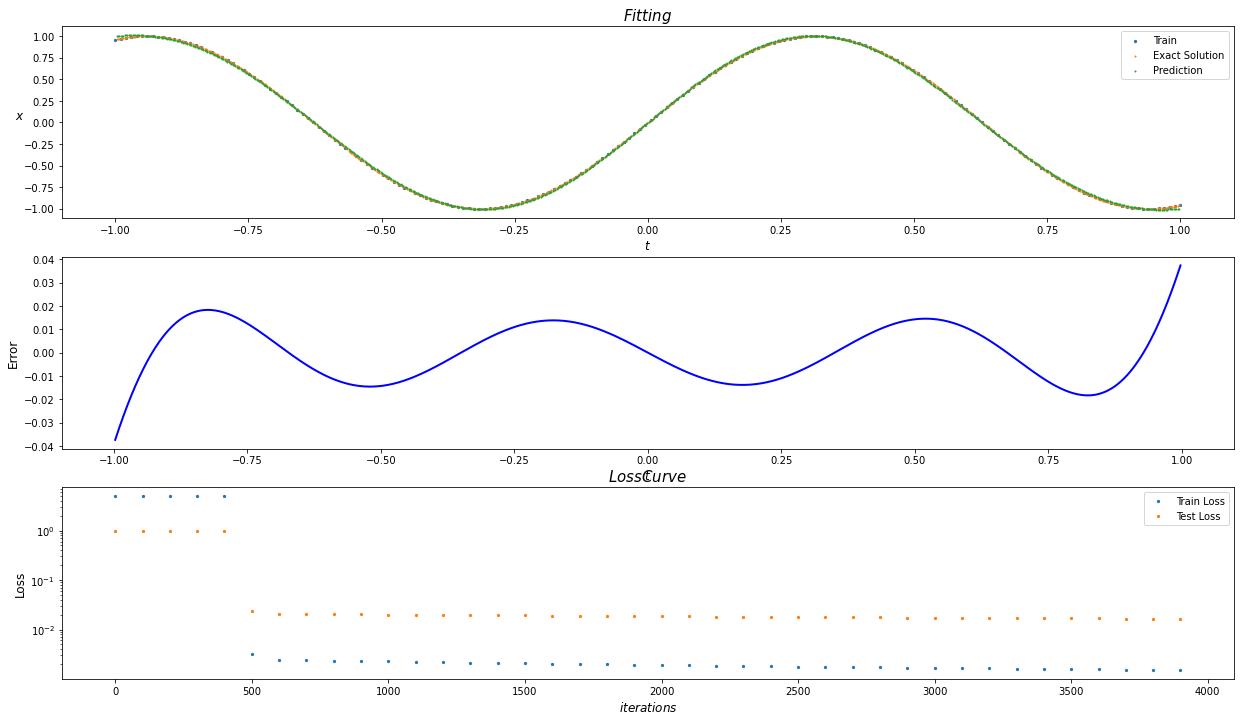

In [5]:
%matplotlib inline

######################################################################
############################# Plotting ###############################
######################################################################    
fig = plt.figure(figsize=(21, 12))

ax = plt.subplot(311)
ax.scatter(t_train, x_train, s=5, label="Train")
ax.scatter(t_test, x_test, s=1, label="Exact Solution")
ax.scatter(t_test, model.net(t_test), s=1, label="Prediction")
ax.legend()
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("$x$", fontsize = 12, rotation = 0)
ax.set_title("$Fitting$", fontsize = 15)

ax = plt.subplot(312)
ax.plot(t_test, x_test - model.net(t_test), "b-", linewidth = 2)
ax.set_xlabel("$t$", fontsize = 12)
ax.set_ylabel("Error", fontsize = 12, rotation = 90)

ax = plt.subplot(313)
loss_train = np.array(model.loss_history["train"])
loss_test = np.array(model.loss_history["test"])
ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=5, label="Train Loss")
ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=5, label="Test Loss")
ax.legend()
ax.set_xlabel("$iterations$", fontsize = 12)
ax.set_ylabel("Loss", fontsize = 12, rotation = 90)
ax.set_yscale("log")
ax.set_title('$Loss Curve$', fontsize = 15)